# Resource conservation in genetic code

This notebook performs the analysis of resource conservation of carbon and nitrogen in the genetic code, comparing the standard code with a large number of alternative, artificially generated codes, as proposed by Shenhav and Zeevi, Science, 2020. It also tests whether the observed results for resource conservation can be explained using optimization for hydropathy, polar requirement or volume of the amino acids.

Requirements: The code is written in **Python 3**. The following three packages need to be installed:

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

## Helper functions and global variables

### Transitions and transversions

In [2]:
transitions = {'A':'G', 'G':'A', 'C':'T', 'T':'C'}
transversions = {'A':['C', 'T'], 'G':['C', 'T'], 'C':['A', 'G'], 'T':['A', 'G']}

Function that generates all neighbouring codons of a codon reachable via a transition:

In [3]:
def gen_neighbouring_codons_ti(codon):
    return [transitions[codon[0]]+codon[1:], 
        codon[0]+transitions[codon[1]]+codon[2],
        codon[:2]+transitions[codon[2]]]   

Function that generates all neighbouring codons of a codon reachable via a transverson:

In [4]:
def gen_neighbouring_codons_tv(codon):
    return [transversions[codon[0]][0]+codon[1:], 
        transversions[codon[0]][1]+codon[1:],
        codon[0]+transversions[codon[1]][0]+codon[2],
        codon[0]+transversions[codon[1]][1]+codon[2],
        codon[:2]+transversions[codon[2]][0],
        codon[:2]+transversions[codon[2]][1]]  

### Amino acid properties

In [5]:
# number of nitrogen atoms; Shenhav and Zeevi, Science, 2020
nitrogen_atoms = {'A': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1, 'G': 1, 'H': 3, 'I': 1, 'K': 2, 'L': 1, 'M':1, 'N': 2, 
    'P': 1, 'Q': 2, 'R': 4, 'S': 1, 'T': 1, 'V': 1, 'W': 2, 'Y': 1}
# number of carbon atoms; Shenhav and Zeevi, Science, 2020
carbon_atoms = {'A': 3, 'C': 3, 'D': 4, 'E': 5, 'F': 9, 'G': 2, 'H': 6, 'I': 6, 'K': 6, 'L': 6, 'M':5, 'N': 4, 
    'P': 5, 'Q': 5, 'R': 6, 'S': 3, 'T': 4, 'V': 5, 'W': 11, 'Y': 9}
# polar requirement; Woese, Cold Spring Harbor Symposium on Quantitative Biology, 1966
polar_requirement = {'A': 7.0, 'C': 4.8, 'D': 13.0, 'E': 12.5, 'F': 5.0, 'G': 7.9, 'H': 8.4, 'I': 4.9, 
    'K': 10.1, 'L': 4.9, 'M': 5.3, 'N': 10.0, 'P': 6.6, 'Q': 8.6, 'R': 9.1, 'S': 7.5, 'T': 6.6, 'V': 5.6, 
    'W': 5.2, 'Y': 5.4}
# hydropathy; Kyte and Doolittle, J Mol Biol, 1982
hydropathy = {'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8, 'G': -0.4, 'H': -3.2, 'I': 4.5, 
    'K': -3.9, 'L': 3.8, 'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5, 'S': -0.8, 'T': -0.7, 'V': 4.2, 
    'W': -0.9, 'Y': -1.3}
# molecular volume; Grantham, Science, 1974
mol_volume = {'A': 31, 'C': 55, 'D': 54, 'E': 83, 'F': 132, 'G': 3, 'H': 96, 'I': 111, 
    'K': 119, 'L': 111, 'M': 105, 'N': 56, 'P': 32.5, 'Q': 85, 'R': 124, 'S': 32, 'T': 61, 'V': 84, 
    'W': 170, 'Y': 136}
# the Grantham matrix of amino acid distances; Grantham, Science, 1974
grantham_matrix = pandas.read_csv("grantham.tsv", sep="\t", index_col = 0)
grantham_matrix

,S,R,L,P,T,A,V,G,I,F,Y,C,H,Q,N,K,D,E,M,W
S,0,110,145,74,58,99,124,56,142,155,144,112,89,68,46,121,65,80,135,177
R,110,0,102,103,71,112,96,125,97,97,77,180,29,43,86,26,96,54,91,101
L,145,102,0,98,92,96,32,138,5,22,36,198,99,113,153,107,172,138,15,61
P,74,103,98,0,38,27,68,42,95,114,110,169,77,76,91,103,108,93,87,147
T,58,71,92,38,0,58,69,59,89,103,92,149,47,42,65,78,85,65,81,128
A,99,112,96,27,58,0,64,60,94,113,112,195,86,91,111,106,126,107,84,148
V,124,96,32,68,69,64,0,109,29,50,55,192,84,96,133,97,152,121,21,88
G,56,125,138,42,59,60,109,0,135,153,147,159,98,87,80,127,94,98,127,184
I,142,97,5,95,89,94,29,135,0,21,33,198,94,109,149,102,168,134,10,61
F,155,97,22,114,103,113,50,153,21,0,22,205,100,116,158,102,177,140,28,40


### Codon abundances

Codon abundances from 39 organisms, as used by Shenhav and Zeevi, Fig. 4 (original source of the data: Athey, BMC Bioinformatics, 2017).

In [6]:
codon_abundances = pandas.read_csv("codons_abundances.csv", index_col="Species")
# normalize
codon_abundances["sum"] = codon_abundances.sum(axis=1)
codon_abundances = codon_abundances.loc[:,"TTT":"GGG"].div(codon_abundances["sum"], axis=0)
codon_abundances

,TTT,TTC,TTA,TTG,CTT,CTC,CTA,CTG,ATT,ATC,...,CGA,CGG,AGT,AGC,AGA,AGG,GGT,GGC,GGA,GGG
Species,,,,,,,,,,,,,,,,,,,,,
Escherichia coli,0.022272,0.016333,0.013623,0.013200,0.011678,0.010955,0.003977,0.051326,0.029764,0.024562,...,0.003796,0.006062,0.009205,0.015794,0.002711,0.001689,0.024344,0.028417,0.008636,0.011247
Bacillus subtilis,0.029902,0.014492,0.018661,0.014795,0.022979,0.011292,0.004348,0.024125,0.036057,0.027605,...,0.003781,0.007026,0.006406,0.014194,0.010606,0.003813,0.012549,0.024139,0.021719,0.011159
Natronobacterium gregoryi SP2,0.005295,0.026932,0.001506,0.006181,0.005745,0.048599,0.002853,0.024215,0.005318,0.035001,...,0.013543,0.018691,0.005648,0.012255,0.002168,0.001805,0.014192,0.038010,0.012249,0.015762
Streptomyces coelicolor A3(2),0.000441,0.025880,0.000063,0.002428,0.001609,0.036529,0.000359,0.060785,0.000634,0.027669,...,0.002589,0.031708,0.001512,0.012404,0.000776,0.003648,0.009214,0.061030,0.007141,0.018068
Deinococcus radiodurans R1,0.010590,0.020760,0.000677,0.007422,0.004948,0.034218,0.001372,0.068345,0.010019,0.022081,...,0.002197,0.020535,0.004529,0.023968,0.000965,0.001995,0.007219,0.058150,0.005437,0.020614
Azotobacter vinelandii,0.002740,0.032100,0.000451,0.006903,0.003082,0.024052,0.001298,0.069679,0.004335,0.042346,...,0.002172,0.010859,0.003190,0.024152,0.000829,0.002424,0.012301,0.069409,0.004380,0.008922
Mycoplasma genitalium,0.036439,0.011406,0.031889,0.014841,0.013445,0.008107,0.013409,0.005048,0.027199,0.022173,...,0.001128,0.001119,0.047514,0.008669,0.012770,0.006675,0.021639,0.008746,0.014465,0.018176
Acidianus brierleyi,0.033612,0.013404,0.045393,0.010862,0.018228,0.004011,0.016753,0.003162,0.035097,0.006599,...,0.001058,0.000245,0.014623,0.006156,0.026651,0.008375,0.018843,0.006470,0.033579,0.005159
Pyrolobus fumarii 1A,0.006663,0.019546,0.005175,0.012536,0.017240,0.031382,0.026743,0.020520,0.009247,0.016971,...,0.003686,0.005500,0.008733,0.018347,0.013736,0.029626,0.021228,0.031076,0.008383,0.014051


### Function to read a genetic code from file

Format of the file: Tab-delimited file with two columns, amino acid in the first one, codon in the second. First line is header.

In [7]:
def read_code(fileName):
    code = {}
    with open(fileName, 'r') as f:
        lines = f.read().split("\n")
        # remove the header
        lines.pop(0)
        for l in lines:
            if l!="":
                splitLine = l.split("\t")
                #print(splitLine)
                code[splitLine[1]] = splitLine[0]
    return code

### Function to generate all codons

In [8]:
def gen_all_codons():
    res = []
    bases = ['A', 'C', 'G', 'T']
    for c1 in bases:
        for c2 in bases:
            for c3 in bases:
                res = res+[c1+c2+c3]
    return res

## Generators of random codes

Below we define several different methods of generating alternative codes.

### Amino acid permutation

Maintains the block structure of the standard genetic code, but changes which codons correspond to which amino acid. Position of the stop codons is fixed.

Aka "Amino Acid Shuffler", Caporaso, J Mol Evol, 2005.

In [9]:
# standard_code ... dictionary containing the standard code; keys = codons, values = amino acids
def rand_aa_shuffler(standard_code, seed = 0):
    np.random.seed(seed)
    # all amino acids
    aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '*']
    # dictionary to store the code
    code = {}
    # randomly shuffle the amino acids 
    shuffled_aas = np.random.permutation(20)
    # the last one is always stop
    shuffled_aas = np.append(shuffled_aas, [20])
    # go over the standard code and always change amino acid i to shuffled_aas[i]
    for codon, aa in standard_code.items():
        code[codon] = aas[shuffled_aas[aas.index(aa)]]
    return code

### Amino acid permutation with restriction on the change in number of codons per amino acid

Amino acid frequency in proteins is positively correlated with number of codons of the amino acid (Gilis, Genome Biology, 2001). This function generates randomized codes using amino acid permutation, but only permutations where number of codons of each amino acid changes by at most `max_diff` are allowed. Position of the stop codons is fixed.

In [10]:
# standard_code ... dictionary containing the standard code; keys = codons, values = amino acids
# max_diff ... maximal allowed change in number of codons per amino acid
def rand_aa_shuffler_numRestricted(standard_code, max_diff, seed = 0):
    np.random.seed(seed)

    # count the number of codons for each amino acid in the standard code
    old_aas, counts = np.unique(list(standard_code.values()), return_counts=True)
    old_aas = old_aas.tolist()
    counts = counts.tolist()
    # delete entries corresponding to stop codons, as they are not permuted
    stop_index = old_aas.index('*')
    del old_aas[stop_index]
    del counts[stop_index]
    # an array to store the new permutation of amino acids
    new_aas = ['']*20
    # an array indicating whether an amino acid has been assigned a codon block already
    used = [False]*20

    # iterate over blocks of given size, from the largest to the smallest
    for blockSize in [6,4,3,2,1]:
        # choose all blocks of given size and shuffle them
        blocks = [x for x in range(len(counts)) if counts[x]==blockSize]
        np.random.shuffle(blocks)
        # amino acids that need to be placed in this step (otherwise their number of codons would change to much)
        must_have_pos = [old_aas[x] for x in range(len(old_aas)) if counts[x]==blockSize+max_diff and not used[x]]
        # place those amino acids to the first len(must_have_pos) blocks and mark them as used
        for i in range(len(must_have_pos)):
            aa = must_have_pos[i]
            new_aas[blocks[i]] = aa
            used[old_aas.index(aa)] = True
        # amino acids that may get a position now
        may_have_pos = [old_aas[x] for x in range(len(old_aas)) if counts[x]>=blockSize-max_diff and counts[x]<blockSize+max_diff and not used[x]]
        # shuffle the potential amino acids and fill in the remaining blocks
        np.random.shuffle(may_have_pos)
        for i in range(len(must_have_pos), len(blocks)):
            aa = may_have_pos[i-len(must_have_pos)]
            new_aas[blocks[i]] = aa
            used[old_aas.index(aa)] = True

    # construct the new code
    old_aas += ['*']
    new_aas += ['*']
    code = {}
    for codon, aa in standard_code.items():
        code[codon] = new_aas[old_aas.index(aa)]

    return code	

### The randomization scheme of Shenhav & Zeevi

Randomizes the first two positions of codons, while maintaining that the two sets of first and second positions in which the stop codons reside are separated by a single transition mutation.

Aka "Quartet Shuffler" from Caporaso, J Mol Evol, 2005.

In [11]:
# standard_code ... dictionary containing the standard code; keys = codons, values = amino acids
def rand_quartet_shuffler(standard_code, seed = 0):
    np.random.seed(seed)
    code = standard_code.copy()
    bases = ['A', 'C', 'G', 'T']
    # all possible pairs of bases
    pairs = ['TA', 'TG', 'TT', 'TC', 'CT', 'CC', 'CA', 'CG', 'AT', 'AC', 'AA', 'AG', 'GT', 'GC', 'GA', 'GG']
    # permutation of the pairs to construct the alternative codon
    perm_pairs = pairs.copy()
    np.random.shuffle(perm_pairs)
    
    # the "opal" stop codon is separated by a transition from the "ambre" stop codon
    stop_pair_1 = perm_pairs[0]
    # the transition can happen in the first, or in the second position
    transition_pos = np.random.randint(2)
    if transition_pos==0:
        stop_pair_2 = transitions[stop_pair_1[0]]+stop_pair_1[1]
    else:
        stop_pair_2 = stop_pair_1[0]+transitions[stop_pair_1[1]]
    tmp_pos = perm_pairs.index(stop_pair_2)
    perm_pairs[tmp_pos] = perm_pairs[1]
    perm_pairs[1] = stop_pair_2
    # construct the new code
    for i in range(len(pairs)):   
        for b in bases:
            old_codon = pairs[i]+b
            new_codon = perm_pairs[i]+b
            code[new_codon] = standard_code[old_codon]
                                            
    return code

### The "N-block Shuffler", Caporaso, J Mol Evol, 2005

"The N-Blocks of the genetic code are held constant. We define an N-Block as a 1-, 2-, or 4-codon block in which all codons specify the same amino acid. The block structure is defined based on the canonical code, and all blocks of the same size are permuted among themselves. (...) The N-Block Shuffler maintains the number of codons per amino acid and the block structure of the genetic code." The position of stop codons is fixed.

In [12]:
def rand_N_block_shuffler(seed = 0):
    np.random.seed(seed)
    
    # the block structure of the standard code
    N_blocks_1 = ['ATA', 'ATG', 'TGG']
    N_blocks_1_aas = ['I', 'M', 'W']
    N_blocks_2 = [['TTT', 'TTC'], ['TTA', 'TTG'], ['TAT', 'TAC'], ['TGT', 'TGC'], ['CAT', 'CAC'], ['CAA', 'CAG'],
        ['ATT', 'ATC'], ['AAT', 'AAC'], ['AAA', 'AAG'], ['AGT', 'AGC'], ['AGA', 'AGG'], ['GAT', 'GAC'], ['GAA', 'GAG']]
    N_blocks_2_aas = ['F', 'L', 'Y', 'C', 'H', 'Q', 'I', 'N', 'K', 'S', 'R', 'D', 'E']
    N_blocks_4 = [['TCT', 'TCC', 'TCA', 'TCG'], ['CTT', 'CTC', 'CTA', 'CTG'], ['CCT', 'CCC', 'CCA', 'CCG'], 
        ['CGT', 'CGC', 'CGA', 'CGG'], ['ACT', 'ACC', 'ACA', 'ACG'], ['GTT', 'GTC', 'GTA', 'GTG'], ['GCT', 'GCC', 'GCA', 'GCG'],
        ['GGT', 'GGC', 'GGA', 'GGG']]
    N_blocks_4_aas = ['S', 'L', 'P', 'R', 'T', 'V', 'A', 'G']
    stop_codons = ['TAA', 'TAG', 'TGA']
    
    code = {}
    # shuffle 1-blocks
    perm1 = np.random.permutation(len(N_blocks_1))
    for i in range(len(N_blocks_1)):
        code[N_blocks_1[i]] = N_blocks_1_aas[perm1[i]]
    # shuffle 2-blocks
    perm2 = np.random.permutation(len(N_blocks_2))
    for i in range(len(N_blocks_2)):
        for codon in N_blocks_2[i]:
            code[codon] = N_blocks_2_aas[perm2[i]]
    # shuffle 4-blocks
    perm4 = np.random.permutation(len(N_blocks_4))
    for i in range(len(N_blocks_4)):
        for codon in N_blocks_4[i]:
            code[codon] = N_blocks_4_aas[perm4[i]]
    # add stop codons
    for codon in stop_codons:
        code[codon] = "*"

    return code

### The "Codon Shuffler", Caporaso, J Mol Evol, 2005

Amino acids are assigned to codons randomly, but the number of codons each amino acid has is preserved.
Maintains the number of codons per amino acid, but produces codes without block structure. Position of stop codons fixed.

In [13]:
def rand_codon_shuffler(standard_code, seed = 0):
    np.random.seed(seed)
    # dictionary to store the code
    code = standard_code.copy()
    # count the number of codons for each amino acid
    values, counts = np.unique(list(standard_code.values()), return_counts=True)
    # shuffle the codons
    # stop codons are fixed - don't include them in the permutation
    codons = list(standard_code.keys())
    perm = np.random.permutation(64)
    codons = [codons[x] for x in perm if codons[x] not in ['TAA', 'TAG', 'TGA']]
    # assign the codons to amino acids
    start = 0
    for i in range(len(values)):
        aa = values[i]
        if aa!="*":
            count = counts[i]
            for j in range(start, start+count):
                code[codons[j]]=aa
            start = start+count
    return code

### The "AAAGALOC Shuffler", Caporaso, J Mol Evol, 2005

Generates completely random codes, the only restriction is that each amino acid has at least one codon. The resulting codes do not in general have a block structure. Number of codons per amino acid is not preserved. Position of stop codons fixed.

In [14]:
def rand_aaagaloc_shuffler(standard_code, seed = 0):
    np.random.seed(seed)
    # dictionary to store the code
    code = {}
    # list of amino acids
    aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    # fix stop codons
    code['TAA'] = "*"
    code['TAG'] = "*"
    code['TGA'] = "*"
    # shuffle the codons
    # stop codons are fixed - don't include them in the permutation
    codons = list(standard_code.keys())
    perm = np.random.permutation(64)
    codons = [codons[x] for x in perm if codons[x] not in ['TAA', 'TAG', 'TGA']]
    # the first 20 codons are assigned each to the corresponding amino acid
    # to fulfill the requirement that each amino acid has at least one codon
    for i in range(20):
        code[codons[i]] = aas[i]
    # the remaining codons are assigned to amino acids randomly
    for i in range(41):
        codon = codons[20+i]
        aa = aas[np.random.randint(0,20)]
        code[codon] = aa

    return code

### The Massey models, J Mol Evol, 2008

The models by Massey (J Mol Evol, 2008) attempt to model the evolution of the genetic code, in particular the stepwise addition of new amino acids to the growing code.

The amino acid to be added next is chosen randomly from all not yet placed amino acids with probability proportional to its physicochemical similarity to the parent acid. The physicochemical similarity is defined as 1/*d*, where *d* is the Grantham distance of the proposed amino acid and the parent amino acid.

These models preserve the block structure of the genetic code. Further, the models tend to create codes in which neighbouring amino acids are physicochemically similar.

#### Model 1

In Model 1, we start with a random amino acid assigned to a random codon block. Subsequent amino acids are chosen based on their similarity with the amino acid previously added to the code and placed in a randomly chosen codon block neighbouring the previous one. If no such codon block exists, a codon block is chosen randomly from the remaining free blocks.

In [15]:
'''
Helper function to get all neighbouring codon blocks of a given block.
bl ... a codon block; list of codons
blocks ... a list of blocks, each list of codons
'''
def get_neighbouring_blocks(bl, blocks):
    neighbours = []
    for codon in bl:
        neighbours.append(gen_neighbouring_codons_ti(codon)+gen_neighbouring_codons_tv(codon))
    neighbours = np.unique(neighbours)
    # return blocks that share at least one element with neighbours
    return [b for b in blocks if set(b) & set(neighbours)]

In [16]:
def rand_massey_1_shuffler(seed = 0):
    np.random.seed(seed)
    # dictionary to store the code
    code = {}
    # define the blocks of the code
    blocks = [["TTT", "TTC"], ["TAT", "TAC"], ["ATA", "ATC", "ATT"], ["AAT", "AAC"], 
        ["AGT", "AGC", "TCA", "TCC", "TCG", "TCT"], ["ACA", "ACC", "ACG", "ACT"], ["TGT", "TGC"], 
        ["CGA", "CGC", "CGG", "CGT", "AGA", "AGG"], ["TTA", "TTG", "CTA", "CTC", "CTG", "CTT"],
        ["CCA", "CCC", "CCT", "CCG"], ["CAT", "CAC"], ["GTG", "GTT", "GTA", "GTC"], 
        ["GCA", "GCG", "GCC", "GCT"], ["GAT", "GAC"], ["GGA", "GGC", "GGG", "GGT"], 
        ["TGG"], ["CAA", "CAG"], ["ATG"], ["AAA", "AAG"], ["GAA", "GAG"]]
    # list of aminoacids 
    aminoacids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

    previous_block = None
    previous_aa = None
    for i in range(20):
        # the first amino acid and block
        if previous_aa == None:
            # choose random block and random amino acid
            next_block = blocks[np.random.randint(len(blocks))]
            next_aa = aminoacids[np.random.randint(len(aminoacids))]
        else:
            # choose a block neighbouring the previous one
            candidate_blocks = get_neighbouring_blocks(previous_block, blocks)
            # at least one neighbouring block is free
            if len(candidate_blocks)>0:
                # choose a random one from the neighbouring blocks
                next_block = candidate_blocks[np.random.randint(len(candidate_blocks))]
            # there are no free neighbouring blocks
            else:
                # choose a random block from all remaining free blocks
                next_block = blocks[np.random.randint(len(blocks))]
            # probabilities of adding the individual amino acids
            probs = [1/grantham_matrix.at[previous_aa, aa] for aa in aminoacids]
            probs = [x/sum(probs) for x in probs]
            # choose the next amino acid
            next_aa = aminoacids[np.random.choice(len(aminoacids), p=probs)]            
        # update aminoacids and blocks    
        del aminoacids[aminoacids.index(next_aa)]
        del blocks[blocks.index(next_block)]
        # add the new codons to the code
        for codon in next_block:
            code[codon] = next_aa
        previous_block = next_block
        previous_aa = next_aa  

    # add stop codons
    stop_codons = ["TAA", "TAG", "TGA"]
    for stop in stop_codons:
        code[stop] = "*"

    return code

#### Model 2 and Model 3 ('213' model)

In Model 2 and Model 3 (the '213' model) the codon blocks are added in order specified by Fig. 2a, 2b and 3 in Massey, J Mol Evol, 2008. In addition, in Model 3 the four starting amino acids are fixed (V, A, D, and G).

Below we define the order of adding blocks, as well as the parent of each newly added block (0 if no parent) for models 2a, 2b and the 213 model:

In [17]:
# Model 2a
blocks_massey_2a = [["TTT", "TTC"], ["TAT", "TAC"], ["ATA", "ATC", "ATT"], ["AAT", "AAC"], 
        ["AGT", "AGC", "TCA", "TCC", "TCG", "TCT"], ["ACA", "ACC", "ACG", "ACT"], ["TGT", "TGC"], 
        ["CGA", "CGC", "CGG", "CGT", "AGA", "AGG"], ["TTA", "TTG", "CTA", "CTC", "CTG", "CTT"],
        ["CCA", "CCC", "CCT", "CCG"], ["CAT", "CAC"], ["GTG", "GTT", "GTA", "GTC"], 
        ["GCA", "GCG", "GCC", "GCT"], ["GAT", "GAC"], ["GGA", "GGC", "GGG", "GGT"], 
        ["TGG"], ["CAA", "CAG"], ["ATG"], ["AAA", "AAG"], ["GAA", "GAG"]]
parents_massey_2a = [0, 0, 1, 2, 1, 3, 2, 4, 1, 5, 2, 3, 6, 4, 0, 7, 11, 3, 4, 14]

# Model 2b
blocks_massey_2b = [["TTA", "TTG", "CTA", "CTC", "CTG", "CTT"], ["CAT", "CAC"], ["GTG", "GTT", "GTA", "GTC"],
    ["GAT", "GAC"], ["CCA", "CCC", "CCT", "CCG"], ["CGA", "CGC", "CGG", "CGT", "AGA", "AGG"], 
    ["GCA", "GCG", "GCC", "GCT"], ["GGA", "GGC", "GGG", "GGT"], ["TTT", "TTC"], 
    ["AGT", "AGC", "TCA", "TCC", "TCG", "TCT"], ["TAT", "TAC"], ["TGT", "TGC"], ["ATA", "ATC", "ATT"], 
    ["ACA", "ACC", "ACG", "ACT"], ["AAT", "AAC"], ["TGG"], ["ATG"], ["CAA", "CAG"], ["AAA", "AAG"], 
    ["GAA", "GAG"]]
parents_massey_2b = [0, 0, 1, 2, 1, 2, 3, 4, 1, 5, 2, 6, 3, 7, 4, 12, 13, 2, 15, 4]

# Model 3 (213 model)
blocks_213 = [["GTG", "GTT", "GTA", "GTC"], ["GCA", "GCG", "GCC", "GCT"], ["GAT", "GAC"],
    ["GGA", "GGC", "GGG", "GGT"], ["TTA", "TTG", "CTA", "CTC", "CTG", "CTT"],  ["CCA", "CCC", "CCT", "CCG"],
    ["CAT", "CAC"], ["CGA", "CGC", "CGG", "CGT", "AGA", "AGG"], ["TTT", "TTC"], 
    ["AGT", "AGC", "TCA", "TCC", "TCG", "TCT"], ["TAT", "TAC"], ["TGT", "TGC"], ["ATA", "ATC", "ATT"], 
    ["ACA", "ACC", "ACG", "ACT"], ["AAT", "AAC"], ["TGG"], ["CAA", "CAG"], ["ATG"], ["AAA", "AAG"], 
    ["GAA", "GAG"]]
parents_213 = [0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 12, 7, 13, 15, 3]
fixed_aas_213 = {1: 'V', 2: 'A', 3: 'D', 4: 'G'}

The function to generate codes according to models 2a, 2b or 3:

In [18]:
'''
blocks ... the codon blocks, in the order in which they are added to the code; list of lists of codons
parents ... a list of the same length as blocks, specifying the parent for each block in blocks; 
    0 if a block has no parent
fixed_aas ... a dictionary in the form index:aa, index is index of a block, aa the amino acid that will be
    assigned to this block; None if not applicable (no blocks with fixed meaning)
'''
def rand_massey_2_3_shuffler(blocks, parents, fixed_aas = None, seed = 0):
    np.random.seed(seed)
    # list of amino acids
    aminoacids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    # list to store the amino acids added to the code
    new_aas = []
    # a dictionary to store the code
    code = {}
    for i in range(len(blocks)):
        # no parent: either use the specified fixed aas or choose a random amino acid
        if parents[i]==0:
            if fixed_aas == None:
                aa = aminoacids[np.random.randint(len(aminoacids))]
            else:
                aa = fixed_aas[i+1]
        # choose amino acid with probability proportional to 1/d(parent, aa), d the Grantham distance
        else:
            parent_aa = new_aas[parents[i]-1]
            # the probabilities of choosing the individual amino acids
            probs = [1/grantham_matrix.at[parent_aa, aa] for aa in aminoacids]
            probs = [x/sum(probs) for x in probs]
            # choose a random amino acid with probability proportional to probs
            aa = aminoacids[np.random.choice(len(aminoacids), p=probs)]
        # update new_aas, delete the newly added amino acid from aminoacids
        new_aas.append(aa)
        del aminoacids[aminoacids.index(aa)]
        # update the code
        for codon in blocks[i]:
            code[codon] = aa

    # add stop codons
    stop_codons = ["TAA", "TAG", "TGA"]
    for stop in stop_codons:
        code[stop] = "*"

    return code

## ERMC

The following function computes the expected random mutation cost (ERMC), as defined by Shehav and Zeevi, Science, 2020.

Parameters:
* code ... the genetic code; dictionary, keys = codons, values = amino acids
* property_dict ... a dictionary with a chosen property of amino acids; keys = amino acids, values = values of the property; e.g. the `nitrogen_atoms`, `oxygen_atoms`, `polar_requirement`, `hydropathy` or `mol_volume` dictionaries defined above
* mutRates ... a list of length two, the first item gives the mutation rate of a transition, the second item the mutation rate of a transversion
* codons_frequencies ... a dictionary containing the codon frequencies; keys = codons, values = frequencies
* abs_val ... specifies if ERMC should be computed using absolute values of the differences in the property between the starting and ending amino acid (if abs_val==True), or if only positive differences should be taken into account (if abs_val==False); default False

In [19]:
def ERMC(code, property_dict, mutRates, codons_frequencies, abs_val=False):
    # mutation rates of a transition and a transversion
    rate_tis = mutRates[0]
    rate_tvs = mutRates[1]

    ermc = 0

    codons = list(code.keys())
    for c in codons:
        aa = code[c]
        freq = codons_frequencies[c]
        if aa!="*":
            # transitions
            neighs_ti = gen_neighbouring_codons_ti(c)
            for n in neighs_ti:
                n_aa = code[n]
                if n_aa!="*":
                    # use absolute values in the computation of ERMC (used for mol. volume, PR, hydropathy)
                    if abs_val == True:
                        ermc += freq * rate_tis * abs(property_dict[n_aa] - property_dict[aa])
                    # use only positive differeneces (for carbon and nitrogen conservation)   
                    else:
                        ermc += freq * rate_tis * max(0, property_dict[n_aa] - property_dict[aa])
                    
            # transversions
            neighs_tv = gen_neighbouring_codons_tv(c)
            for n in neighs_tv:
                n_aa = code[n]
                if n_aa!="*":
                    # use absolute values in the computation of ERMC (used for mol. volume, PR, hydropathy)
                    if abs_val == True:
                        ermc += freq * rate_tvs * abs(property_dict[n_aa] - property_dict[aa])
                    # use only positive differeneces (for carbon and nitrogen conservation)   
                    else:
                        ermc += freq * rate_tvs * max(0, property_dict[n_aa] - property_dict[aa])
    
    return ermc

Function to compute all of the following:
* ERMC in carbon conservation
* ERMC in nitrogen conservation
* ERMC in hydropathy
* ERMC in polar requirement
* ERMC in molecular volume
for a given genetic code.

In [20]:
def compute_code_characteristics(code, mutRates, codons_frequencies):
    ermc_c = ERMC(code, carbon_atoms, mutRates, codons_frequencies, False)
    ermc_n = ERMC(code, nitrogen_atoms, mutRates, codons_frequencies, False)
    ermc_hydropathy = ERMC(code, hydropathy, mutRates, codons_frequencies, True)
    ermc_polarreq = ERMC(code, polar_requirement, mutRates, codons_frequencies, True)
    ermc_volume = ERMC(code, mol_volume, mutRates, codons_frequencies, True)
    return [ermc_c, ermc_n, ermc_hydropathy, ermc_polarreq, ermc_volume]

## Plotting

Below we provide a function to plot the results. 

Parameters:
* res ... the numpy array with results from randomized codes, as generated below
* variable1 ... the plotted variable; one from "nitrogen", "carbon", "hydropathy", "PR", "volume"
* variable2 ... if specified, only codes performing at least as good as the standard code in variable2 will be chosen for plotting variable1; one from "nitrogen", "carbon", "hydropathy", "PR", "volume"

In [21]:
def plot_code_histograms(res, variable1, variable2 = None):
    indexes = {"nitrogen": 1, "carbon": 0, "hydropathy": 2, "PR": 3, "volume": 4}
    colors = {"nitrogen": '#0d4c7c', "carbon": '#151515', "hydropathy": '#018571', "PR":  '#660099', "volume": "#330000"}
   
    if variable2 == None:
        results = res[:,indexes[variable1]]
    else: 
        results = res[:,indexes[variable1]][res[:,indexes[variable2]]<=res[0,indexes[variable2]]] 
                          
    color = colors[variable1]
    
    _, ax = plt.subplots(1, figsize =(3.5,2.333), dpi=144)
    ax.hist(results, color=color, bins=50, density=True)
    ax.axvline(results[0], color='red', lw=1)
    ax.axvline(results[0], color='k', lw=0.6)
    if variable2 == None:
        print('{}, p={}'.format(variable1, sum(results<=results[0])/len(results)))
    else:
        print('{} confounded by {}, n={}, p={}'.format(variable1, variable2, len(results), sum(results<=results[0])/len(results)))
    plt.show()

# Main

This part of the code performs the actual analysis.

**SPECIFY THE PARAMETERS HERE:**

In [22]:
# number of codes to generate
num_codes = 10000

# randomization type; one of: aa, aa_restricted, quartet, nblock, codon, aaagaloc, massey_1, massey_2a,
#     massey_2b, 213
# see above for description of the individual randomization schemes
randomization_type = "aa"

# maximum difference between number of codons per aa in the alternative codes and the standard one
# only used when randomization_type = "aa_restricted"
max_diff = 2

# transition:transversion ratio
ti_tv_ratio = 0.5

# organism from which codon frequencies should be used (one of the species in `codon_abundances` - see above)
# "null" if all codon frequencies should be equal
organism = 'null'

# number of characteristics of the code; default 5 (carbon conservation, nitrogen conservation, hydropathy, PR, volume)
# ONLY CHANGE THIS IF YOU ADD OR REMOVE SOME OF THE CODE CHARACTERISTICS
num_char = 5

Note: The computation takes a few seconds for 10,000 alternative codes. Please be patient if requiring larger number of codes.

In [23]:
# prepare codon frequencies
if organism == "null":
    codons_frequencies = {}
    codons = gen_all_codons()
    for c in codons:
        codons_frequencies[c] = 1/64
else:
    codons_frequencies = codon_abundances.loc[organism].to_dict()

In [24]:
# compute mutation rates from transition:transversion ratio
rate_tis = (2*ti_tv_ratio)/(1+2*ti_tv_ratio)
mutRates = [rate_tis, 1-rate_tis]
# normalize so that 3*rate_tis + 6*rate_tvs = 1 (there are 3 transitions and 6 transversions from each codon)
mutRates = [x/(3*rate_tis + 6*(1-rate_tis)) for x in mutRates]

In [25]:
# numpy array to store the results
res = np.empty(shape=(num_codes+1, num_char))

# characteristics of the standard code
standard_code = read_code("code_standard.tsv")
res[0,:] = compute_code_characteristics(standard_code, mutRates, codons_frequencies)

# generate num_codes alternative codes and compute their characteristics
for seed in range(num_codes):
    if randomization_type=="aa":
        code = rand_aa_shuffler(standard_code, seed)
    elif randomization_type=="aa_restricted":
        code = rand_aa_shuffler_numRestricted(standard_code, max_diff, seed)
    elif randomization_type=="quartet":
        code = rand_quartet_shuffler(standard_code, seed)
    elif randomization_type=="nblock":
        code = rand_N_block_shuffler(seed)
    elif randomization_type=="codon":
        code = rand_codon_shuffler(standard_code, seed)
    elif randomization_type=="aaagaloc":
        code = rand_aaagaloc_shuffler(standard_code, seed)
    elif randomization_type=="massey_1":
        code = rand_massey_1_shuffler(seed)
    elif randomization_type=="massey_2a":
        code = rand_massey_2_3_shuffler(blocks_massey_2a, parents_massey_2a, None, seed)
    elif randomization_type=="massey_2b":
        code = rand_massey_2_3_shuffler(blocks_massey_2b, parents_massey_2b, None, seed)
    elif randomization_type=="213":
        code = rand_massey_2_3_shuffler(blocks_213, parents_213, fixed_aas_213, seed)
    else:
        print("Randomization type must be one of 'aa', 'aa_restricted', 'quartet', 'nblock', 'codon', 'aaagaloc', 'massey_1', 'massey_2a', 'massey_2b', '213'.")
        quit()
    # compute code characteristics and save
    res[seed+1,:] = compute_code_characteristics(code, mutRates, codons_frequencies)

nitrogen, p=0.48905109489051096


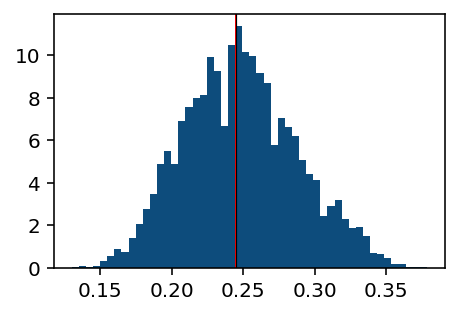

carbon, p=0.0105989401059894


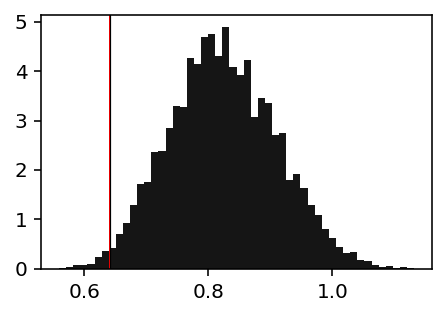

volume, p=0.0458954104589541


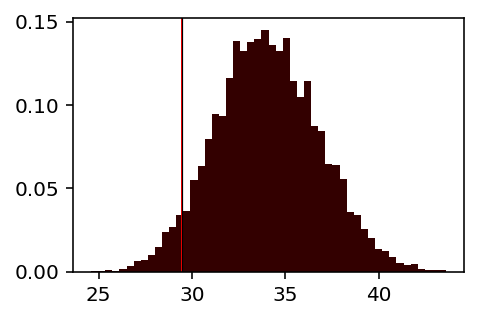

carbon confounded by volume, n=459, p=0.1721132897603486


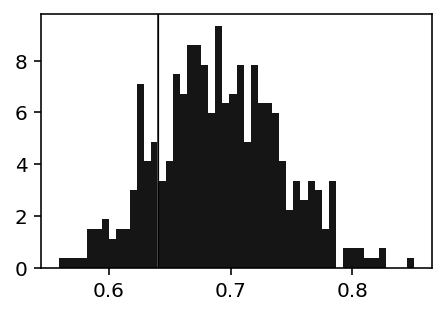

In [26]:
# plots
# histogram of nitrogen conservation
plot_code_histograms(res, "nitrogen")
# carbon conservation
plot_code_histograms(res, "carbon")
# molecular volume
plot_code_histograms(res, "volume")
# carbon conservation confounded by volume
plot_code_histograms(res, "carbon", "volume")